# Анализ поведения пользователей мобильного приложения

Целью исследования является изучение поведения пользователей мобильного приложения стартапа, продающего продукты питания. <br>
Для этого был предоставлен датасет с логами, в которых зафиксированы все действия, совершенные пользователями. <br>

Наша задача изучить воронку событий и исследовать результаты A/A/B-эксперимента. 

**Оглавление**
* [[Загрузка и предобработка данных](#p1)](#section_id)<a id='section_id1'></a>
* [[Изучение и проверка данных](#p2)](#section_id)<a id='section_id2'></a>
* [[Изучение воронки событий](#p3)](#section_id)<a id='section_id3'></a>
* [[Изучение результатов эксперимента](#p4)](#section_id)<a id='section_id4'></a>
* [[Вывод](#p5)](#section_id)<a id='section_id5'></a>

<a id='p1'></a> 
## [Загрузка и предобработка данных](#section_id1)

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
from plotly import graph_objects as go
import warnings

In [2]:
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv(r'C:\Users\spk-s\Downloads\logs_exp.csv', sep='\t')    

In [3]:
# отключение предупреждений об ошибках
warnings.filterwarnings('ignore')

In [4]:
# просмотр общего вида датасета
logs.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
80690,MainScreenAppear,9085753110677473382,1564819422,246
92561,MainScreenAppear,659501983999336229,1564838133,248
165047,CartScreenAppear,5530248251237125348,1565019084,247
56657,MainScreenAppear,1449633191757318122,1564749687,248
230808,MainScreenAppear,6991683592829765144,1565187169,248


In [5]:
# приведение названия столбцов к нужному виду
logs = logs.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash', \
                            'EventTimestamp': 'event_timestamp', 'ExpId': 'exp_id'})

In [6]:
# проверка наличия пропусков и типов данных столбцов
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# проверка наличия дубликатов и удаление
print(f'Выявлено и удалено {logs.duplicated().sum()} дубликатов.')
logs = logs.drop_duplicates()

Выявлено и удалено 413 дубликатов.


In [8]:
# приведение дат к нужному виду
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit='s')

# создание столбца только с датой
logs['date'] = logs['event_timestamp'].dt.date

In [9]:
logs['event_timestamp']

0        2019-07-25 04:43:36
1        2019-07-25 11:11:42
2        2019-07-25 11:28:47
3        2019-07-25 11:28:47
4        2019-07-25 11:48:42
                 ...        
244121   2019-08-07 21:12:25
244122   2019-08-07 21:13:59
244123   2019-08-07 21:14:43
244124   2019-08-07 21:14:58
244125   2019-08-07 21:15:17
Name: event_timestamp, Length: 243713, dtype: datetime64[ns]

В ходе предобработки названия столбцов были изменены на соответствующие "змеиному" регистру, столбец с датами преобразован необходимому виду, пропусков в данных не выявлено, выявленные дубликаты удалены.

<a id='p2'></a> 
## [Изучение и проверка данных](#section_id2)

In [10]:
# подсчет количества событий в логе
count_event = logs['event_name'].count()
print(f'Количество событий в логе: {count_event}')

Количество событий в логе: 243713


In [11]:
# подсчет количества пользователй в логе
count_user = logs['device_id_hash'].nunique()
print(f'Количество уникальных пользователей в логе: {count_user}')

Количество уникальных пользователей в логе: 7551


In [12]:
# подсчет среднего количества событий на пользоватееля
counts = []
for us_id in logs['device_id_hash'].unique():
    counts.append(logs.query('device_id_hash == @us_id').event_name.count())
print(f'Среднее количество событий на пользователя: {round(np.median(counts))}')

Среднее количество событий на пользователя: 20


In [13]:
# определение временного периода предоставленных данных
print(f'Начало периода: {logs["date"].min()}')
print(f'Конец периода:  {logs["date"].max()}')

Начало периода: 2019-07-25
Конец периода:  2019-08-07


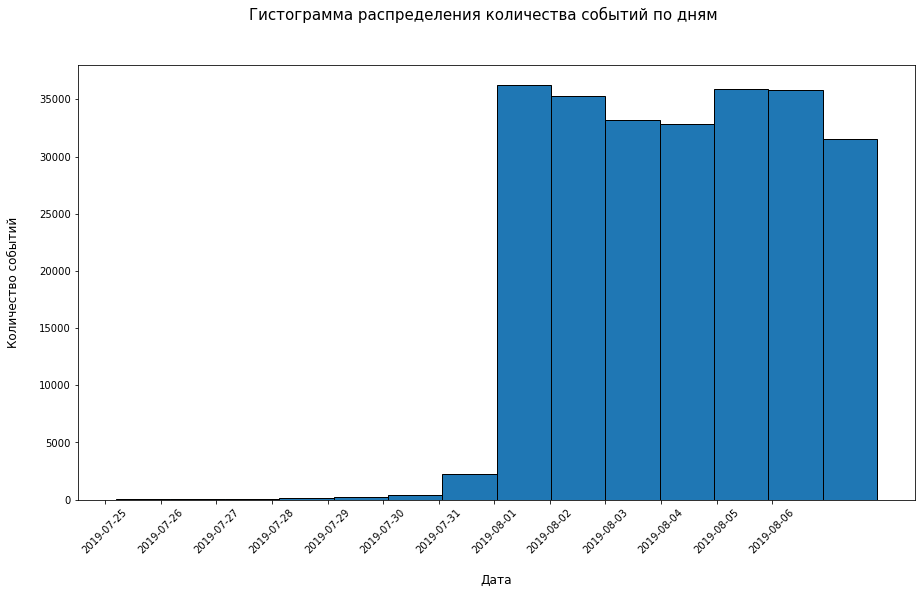

In [14]:
# построение гистограммы распределения количесвта событий по датам
plt.figure(figsize=(15, 8))
plt.hist(logs['event_timestamp'], bins=14, ec='black')

plt.xticks(np.arange(min(logs['date']), max(logs['date']), 1), rotation = 45)
plt.suptitle('Гистограмма распределения количества событий по дням', fontsize=15)
plt.xlabel('\n' + 'Дата', fontsize=12)
plt.ylabel('Количество событий' + '\n', fontsize=12);

По приведенному графику отчетливо видно, что данные за июль не являются релевантными, т. к. содержат неполные данные. Для корректной дальнейшей работы отбросим их.

In [15]:
# удаление данных 
logs = logs.query('date > @pd.to_datetime("2019-07-31")')

In [17]:
# расчет доли удаленных событий
count_event_1 = logs['event_name'].count()
print(f'Доля удаленных событий в логе: {round((1 - count_event_1/count_event), 3) * 100}%.')

# расчет доли удаленных пользователей
count_user_1 = logs['device_id_hash'].nunique()
print(f'Доля уникальных пользователей в логе: {round((1 - count_user_1/count_user), 3) * 100}%.')

Доля удаленных событий в логе: 1.2%.
Доля уникальных пользователей в логе: 0.2%.


Итого, отброшенно не более 1,5% данных датасета, что вполне приемлемо.

In [18]:
# проверка уникальных значений столбца с номерами контрольных групп
logs['exp_id'].unique()

array([246, 247, 248], dtype=int64)

В таблице есть представители всех трех экспериментальных групп.

В ходе изучения данных выяснено:
- в исследовании участвует 7551 пользователь;
- на одного человека, в среднем, приходится 20 событий;
- данные предоставлены за период с 25 июля по 7 августа 2019 года, однако релевантные данные только за август;
- в датасете присутствуют представители всех трех исследуемых групп.

<a id='p3'></a> 
## [Изучение воронки событий](#section_id3)

In [19]:
# частотa происхождения всех событий датасета
logs.event_name.value_counts().sort_values(ascending=False)

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [20]:
# количество пользователей, совершивших каждое из событий
count_users = logs.pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique') \
                  .rename(columns={'device_id_hash': 'amount_users'}) \
                  .sort_values(by='amount_users', ascending=False) \
                  .reset_index()
count_users.columns = ['event', 'amount_users']

# доли пользователей, совершивших каждое из событий
count_all_users = logs['device_id_hash'].nunique()
count_users['frac_of_all, %'] = round((count_users['amount_users']/count_all_users) * 100, 2)

count_users

,event,amount_users,"frac_of_all, %"
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Следуя логике, события должны выстраиваться в цепочку:
- открытие главного экрана;
- открытие экрана с товарами;
- открытие корзины;
- появление отчета об успешной оплате.

Tutorial (инструкция, обучение) не встраивается в эту последовательность, мы не можем четко определить когда пользователю использовать этот раздел. Это же подтверждают предыдущие вычисления - эту страницу посещают намного реже остальных. Скорей всего, потому что ее можно пропустить (не является обязательной).


In [21]:
# исключение туториала из воронки
logs = logs.query('event_name != "Tutorial"')
count_users = count_users.query('event != "Tutorial"')

# добавление столбца с долей перешедших на каждый шаг пользователей (относительно предыдущего)
count_users['frac_of_step, %'] = round((count_users['amount_users']/count_users['amount_users'].shift(1)) * 100, 1).fillna(100)
count_users

# amount_users - количество пользователей, совершивших данное событие
# frac_of_all - доля от общего числа пользователей
# frac_of_step - доля пользователей, перешедших с предыдущего шага

,event,amount_users,"frac_of_all, %","frac_of_step, %"
0,MainScreenAppear,7419,98.47,100.0
1,OffersScreenAppear,4593,60.96,61.9
2,CartScreenAppear,3734,49.56,81.3
3,PaymentScreenSuccessful,3539,46.97,94.8


По таблице видно, что наибольшее количество пользователей (~40%) теряется на этапе перехода с главной страницы на страницу с товарами.

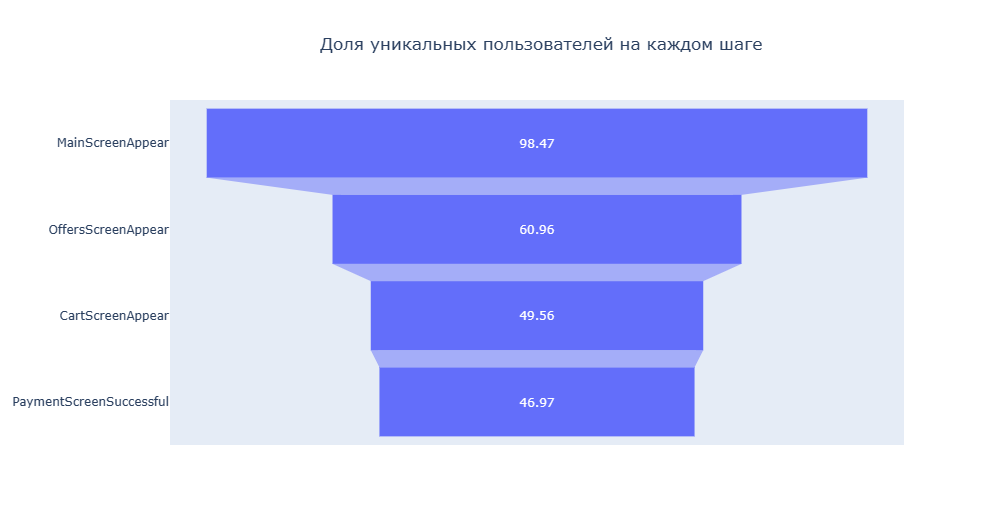

In [45]:
# вычисление доли пользователей, дошедших от первого события до оплаты
print(f"От открытия главной страницы до оплаты товара дошли {round(count_users['amount_users'][3]/count_users['amount_users'][0], 2) * 100}% пользователей приложения.")

От открытия главной страницы до оплаты товара дошли 48.0% пользователей приложения.


<a id='p4'></a> 
## [Изучение результатов эксперимента](#section_id4)
* [Проверка статистической разницы между контрольными группами 246 и 247](#p4s1) 
* [Проверка статистической разницы между контрольными группами 246 и 248](#p4s2)
* [Проверка статистической разницы между контрольными группами 247 и 248](#p4s3)
* [Проверка статистической разницы между контрольными группами 246_and_247 и 248](#p4s4)

In [46]:
# подсчет количества пользователей в каждой экспериментальной группе
group_users = logs.pivot_table(index=['exp_id'], values='device_id_hash', aggfunc=['nunique']).reset_index()
group_users.columns = ['group', 'count_users']
group_users.loc[3] = ['246_and_247', group_users['count_users'][0]+group_users['count_users'][1]]
group_users

,group,count_users
0,246,2483
1,247,2512
2,248,2535
3,246_and_247,4995


In [47]:
# проверка групп на наличие пересекающихся пользователей
duplicated_users = logs.groupby('device_id_hash').agg({'exp_id': ['nunique']})
duplicated_users.columns = ['exp_id']
duplicated_users = duplicated_users.query('exp_id > 1')
print(f'Количество пользователей, попавших более, чем в одну группу: {len(duplicated_users)}')

Количество пользователей, попавших более, чем в одну группу: 0


In [48]:
# подсчет количества пользователей каждой группы, дошедшего до каждого этапа
groups = logs.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique').reset_index()
groups.columns = ['event', '246', '247', '248']
groups['246_and_247'] = groups['246'] + groups['247']

# добавление столбцов с долями пользователей совершивших каждое действие (относительно всех в данной группе)
groups['246, %'] = round((groups['246']/group_users['count_users'][0]) * 100, 2)
groups['247, %'] = round((groups['247']/group_users['count_users'][1]) * 100, 2)
groups['248, %'] = round((groups['248']/group_users['count_users'][2]) * 100, 2)
groups['246_and_247, %'] = round((groups['246_and_247']/group_users['count_users'][3]) * 100, 2)
groups = groups.sort_values(by='246', ascending=False)
groups

,event,246,247,248,246_and_247,"246, %","247, %","248, %","246_and_247, %"
1,MainScreenAppear,2450,2476,2493,4926,98.67,98.57,98.34,98.62
2,OffersScreenAppear,1542,1520,1531,3062,62.10,60.51,60.39,61.30
0,CartScreenAppear,1266,1238,1230,2504,50.99,49.28,48.52,50.13
3,PaymentScreenSuccessful,1200,1158,1181,2358,48.33,46.10,46.59,47.21


Для проверки групп будет использован уровень значимости α = 0.05. Но из-за того, что нам придется сделать 16 тестов, нужно использовать поправку по методу Шидака, чтобы избежать ошибки первого рода по множественном сравнении. Этот метод выбран потому что он наиболее подходящий при большом количестве проверок.

In [49]:
# функция проверки наличия статистической разницы между контрольными группами по каждому событию

def stat_check(step_count_1, step_count_2, all_count_1, all_count_2):
    
    alpha = 1 - (1 - 0.05)**(1/16) # критический уровень статистической значимости с поправакой Шидака для множественных сравнений

    successes = np.array([step_count_1, step_count_2])
    trials = np.array([all_count_1, all_count_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        return ('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
    else:
        return (
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
        ) 

<a id='p4s1'></a>
### Проверка статистической разницы между контрольными группами 246 и 247

Сформулируем гипотезы: <br> Нулевая: различий в пропорциях количества пользователей, выполнивших данное действие, ко всем пользователям группы между группами нет; <br> Альтернативная: различия количества пользователей, выполнивших данное действие, ко всем пользователям группы в пропорциях  между группами есть.

In [50]:
step_count_1 = groups['246'][0]

In [51]:
# проверка статистически значимых различий между группами 246, 247 на шаге MainScreenAppear
step_count_1 = groups['246'][0]
step_count_2 = groups['247'][0]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][1]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [52]:
# проверка статистически значимых различий между группами 246, 247 на шаге OffersScreenAppear  
step_count_1 = groups['246'][1]
step_count_2 = groups['247'][1]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][1]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [53]:
# проверка статистически значимых различий между группами 246, 247 на шаге CartScreenAppear
step_count_1 = groups['246'][2]
step_count_2 = groups['247'][2]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][1]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [54]:
# проверка статистически значимых различий между группами 246, 247 на шаге PaymentScreenSuccessful 
step_count_1 = groups['246'][3]
step_count_2 = groups['247'][3]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][1]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Между контрольными группами ни на одном этапе не обнаружилось статистически значимых различий, значит, что можно переходить к A/B-тестированию, теперь можно быть уверенным, что на точность дальнейших результатов это не повлияет.

<a id='p4s2'></a>
### Проверка статистической разницы между контрольными группами 246 и 248

Гипотезы прежние: <br> Нулевая: различий в пропорциях количества пользователей, выполнивших данное действие, ко всем пользователям группы между группами нет; <br> Альтернативная: различия количества пользователей, выполнивших данное действие, ко всем пользователям группы в пропорциях  между группами есть.

In [55]:
# проверка статистически значимых различий между группами 246, 248 на шаге MainScreenAppear
step_count_1 = groups['246'][0]
step_count_2 = groups['248'][0]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [56]:
# проверка статистически значимых различий между группами 246, 248 на шаге OffersScreenAppear 
step_count_1 = groups['246'][1]
step_count_2 = groups['248'][1]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [57]:
# проверка статистически значимых различий между группами 246, 248 на шаге CartScreenAppear
step_count_1 = groups['246'][2]
step_count_2 = groups['248'][2]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [58]:
# проверка статистически значимых различий между группами 246, 248 на шаге PaymentScreenSuccessful 
step_count_1 = groups['246'][3]
step_count_2 = groups['248'][3]
all_count_1 = group_users['count_users'][0]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


<a id='p4s3'></a>
### Проверка статистической разницы между контрольными группами 247 и 248

Гипотезы прежние: <br> Нулевая: различий в пропорциях количества пользователей, выполнивших данное действие, ко всем пользователям группы между группами нет; <br> Альтернативная: различия количества пользователей, выполнивших данное действие, ко всем пользователям группы в пропорциях  между группами есть.

In [59]:
# проверка статистически значимых различий между группами 247, 248 на шаге MainScreenAppear  
step_count_1 = groups['247'][0]
step_count_2 = groups['248'][0]
all_count_1 = group_users['count_users'][1]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [60]:
# проверка статистически значимых различий между группами 247, 248 на шаге OffersScreenAppear 
step_count_1 = groups['247'][1]
step_count_2 = groups['248'][1]
all_count_1 = group_users['count_users'][1]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [61]:
# проверка статистически значимых различий между группами 247, 248 на шаге CartScreenAppear 
step_count_1 = groups['247'][2]
step_count_2 = groups['248'][2]
all_count_1 = group_users['count_users'][1]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [62]:
# проверка статистически значимых различий между группами 247, 248 на шаге PaymentScreenSuccessful 
step_count_1 = groups['247'][3]
step_count_2 = groups['248'][3]
all_count_1 = group_users['count_users'][1]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


<a id='p4s4'></a>
### Проверка статистической разницы между объединенной контрольной 246_and_247 и экспериментальой 248 группами

Гипотезы прежние: <br> Нулевая: различий в пропорциях количества пользователей, выполнивших данное действие, ко всем пользователям группы между группами нет; <br> Альтернативная: различия количества пользователей, выполнивших данное действие, ко всем пользователям группы в пропорциях  между группами есть.

In [63]:
# проверка статистически значимых различий между группами 246_and_247, 248 на шаге MainScreenAppear
step_count_1 = groups['246_and_247'][0]
step_count_2 = groups['248'][0]
all_count_1 = group_users['count_users'][3]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [64]:
# проверка статистически значимых различий между группами 246_and_247, 248 на шаге OffersScreenAppear 
step_count_1 = groups['246_and_247'][1]
step_count_2 = groups['248'][1]
all_count_1 = group_users['count_users'][3]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [65]:
# проверка статистически значимых различий между группами 246_and_247, 248 на шаге CartScreenAppear 
step_count_1 = groups['246_and_247'][2]
step_count_2 = groups['248'][2]
all_count_1 = group_users['count_users'][3]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


In [66]:
# проверка статистически значимых различий между группами 246_and_247, 248 на шаге PaymentScreenSuccessful 
step_count_1 = groups['246_and_247'][3]
step_count_2 = groups['248'][3]
all_count_1 = group_users['count_users'][3]
all_count_2 = group_users['count_users'][2]

print(stat_check(step_count_1, step_count_2, all_count_1, all_count_2))

p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Как мы можем видеть из проведенных тестов, ни одну из 16 нулевых гипотез не удалось опровергнуть. А это значит, что ни в одном из событий не достигнута статистически значимая разница между группами. Следовательно, проверяемая гипотеза о влиянии шрифтов в приложении на пользователей не подтвердилась.

<a id='p5'></a> 
### [Вывод](#section_id5)

Целью исследования было изучение поведения пользователей мобильного приложения стартапа, продающего продукты питания.
Для этого был предоставлен датасет с логами, в которых зафиксированы все события, совершенные пользователями.
<br> Нашей задачей было изучить воронку событий и исследовать результаты A/A/B-эксперимента.
<br> В ходе предобработки полученных данных, названия столбцов были изменены на соответствующие "змеиному" регистру, а столбец с датами преобразован. Пропусков в данных не выявлено, а найденные дубликаты удалены.
<br> В процессе изучения данных выяснено:
- в эксперименте участвует 7551 пользователь;
- на одного человека, в среднем, приходится 20 событий;
- данные предоставлены за период с 25 июля по 7 августа 2019 года, однако релевантные данные только за август;
- в датасете присутствуют представители всех трех исследуемых групп.

Исходя из выстроенной воронки событий, выстроилась логическая цепочка действий, которые должен производить пользователь:
-	открытие главного экрана;
-	открытие экрана с товарами;
-	открытие корзины;
-	появление отчета об успешной оплате.

Tutorial (инструкция, обучение) же в эту последовательность не встраивается, т. к. мы не можем четко определить когда пользователю использовать этот раздел. Эта страница является аутсайдером по посещениям. Для дальнейших исследований он был исключен.
<br> Далее было замечено, что около 40% пользователей «теряется» на этапе перехода с главной страницы на страницу с товарами. Вероятно, есть возможность попасть на страницу с товарами минуя главный экран. Либо же имеет место неудобное (интуитивно не понятное) оформление приложения.
<br> Также замечено, что от открытия главной страницы до оплаты товара дошли ~48% пользователей приложения.

Для проверки групп изначально был использован уровень значимости α = 0.05. Но т.к. нужно было провести 16 проверок, была внесена поправка по методу Шидака, чтобы избежать ошибки первого рода по множественном сравнении. 
<br> Гипотезы для всех проверок были сформулированы одинаково:
<br> Нулевая: различий в пропорциях количества пользователей, выполнивших данное действие, ко всем пользователям группы между группами нет.
<br> Альтернативная: различия количества пользователей, выполнивших данное действие, ко всем пользователям группы в пропорциях между группами есть.
<br> Между контрольными группами (246 и 247) ни на одном этапе не обнаружилось статистически значимых различий, это означало, что один весомый фактор влияния на точность дальнейшего эксперимента был отсечен.
<br> Однако, в итоге, ни одну из 16 нулевых гипотез не удалось опровергнуть. А это значит, что ни в одном из событий при сравнении всех групп не достигнута статистически значимая разница между группами. Следовательно, проверяемая гипотеза о влиянии шрифтов в приложении на пользователей не подтвердилась.